In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
from dotenv import load_dotenv
import os

# Read data

In [206]:
# Read data from csv
df = pd.read_csv("data/rental_prices_singapore.csv")

In [207]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5360 entries, 0 to 5359
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           5360 non-null   object 
 1   address                        5011 non-null   object 
 2   price                          5360 non-null   object 
 3   size                           5360 non-null   object 
 4   bedrooms                       5360 non-null   object 
 5   bathrooms                      4941 non-null   float64
 6   property_type_furnishing_year  5360 non-null   object 
 7   mrt_distance                   4641 non-null   object 
 8   agent_description              5360 non-null   object 
dtypes: float64(1), object(8)
memory usage: 377.0+ KB


In [208]:
# Show top five rows
df.head()

,name,address,price,size,bedrooms,bathrooms,property_type_furnishing_year,mrt_distance,agent_description
0,"Brand new Attic Studio, in a Peranakan Conserv...",Lorong 34 Geylang,"3,000",400 sqft,1,1.0,\nApartment\nFully Furnished\n,NaN,One and only attic studio! Beautifully done up...
1,Astor,51C Lengkong Empat,"2,000",1130 sqft,Room,NaN,\nApartment\nFully Furnished\n,11 mins (810 m) to DT28 Kaki Bukit MRT,Comes with In House Maid
2,Springhill Terrace,Sunrise avenue,"7,400",3800 sqft,5,4.0,\nApartment\nFully Furnished\n,NaN,"Close to MRT and short drive to French, Austra..."
3,704 Yishun Avenue 5,704 Yishun Avenue 5,"1,000",120 sqft,Room,NaN,\nApartment\nFully Furnished\n,9 mins (700 m) to NS13 Yishun MRT,Room for 1 or 2 single ladies
4,Espada,48 Saint Thomas Walk,"4,300",689 sqft,1,1.0,\nApartment\nFully Furnished\n,6 mins (420 m) to NS23 Somerset MRT,All units virtual online viewing available! An...


# Remove duplicates

In [209]:
# Diagnose duplicates
df.duplicated().value_counts()

False    5082
True      278
dtype: int64

In [210]:
# Remove duplicates
df = df.drop_duplicates().copy()

In [211]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5082 entries, 0 to 5359
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           5082 non-null   object 
 1   address                        4754 non-null   object 
 2   price                          5082 non-null   object 
 3   size                           5082 non-null   object 
 4   bedrooms                       5082 non-null   object 
 5   bathrooms                      4680 non-null   float64
 6   property_type_furnishing_year  5082 non-null   object 
 7   mrt_distance                   4418 non-null   object 
 8   agent_description              5082 non-null   object 
dtypes: float64(1), object(8)
memory usage: 397.0+ KB


# Feature engineering

## Latitude and longitude

In [212]:
# Load environment variables from .env file
load_dotenv()

True

In [213]:
# Get Google Maps API key from .env 
google_maps_api_key = os.getenv("google_maps_api_key")

In [214]:
# Create function to get latitude and longitude from an address 
def get_latitude_longitude(address):
    # Base URL for the Google Maps Geocoding API
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    
    # Parameters for the Geocoding API request
    params = {
        "address": f"{address}, Singapore",
        "key": google_maps_api_key
    }
    
    # Send Geocoding API request and store the response
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Check if request was successful
    if data["status"] == "OK":
        # Extract latitude and longitude from the response
        location = data["results"][0]["geometry"]["location"]
        latitude = location["lat"]
        longitude = location["lng"]
    else:
        # Assign missing values and print error message if the request failed
        latitude = np.nan
        longitude = np.nan
        print(f"Geocoding request failed for {address}")
    
    # Return latitude and longitude
    return (latitude, longitude)

In [215]:
# Apply function to create latitude and longitude column (cost: ~25$)
# df[["latitude", "longitude"]] = df["address"].apply(get_latitude_longitude).apply(pd.Series)

In [216]:
# Save enriched dataframe as csv
# df.to_csv("data/rental_prices_singapore_2.csv", index=False)

In [217]:
# Load enriched data
df = pd.read_csv("data/rental_prices_singapore_2.csv")

In [218]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           5082 non-null   object 
 1   address                        4754 non-null   object 
 2   price                          5082 non-null   object 
 3   size                           5082 non-null   object 
 4   bedrooms                       5082 non-null   object 
 5   bathrooms                      4680 non-null   float64
 6   property_type_furnishing_year  5082 non-null   object 
 7   mrt_distance                   4418 non-null   object 
 8   agent_description              5082 non-null   object 
 9   latitude                       5082 non-null   float64
 10  longitude                      5082 non-null   float64
dtypes: float64(3), object(8)
memory usage: 436.9+ KB


## Meters to school

In [219]:
# Create function to get latitude and longitude of the closest school 
def get_school_location(row):
    # Get latitude and longitude of the property
    property_latitude = row["latitude"]
    property_longitude = row["longitude"]
    
    # Base URL for the Google Maps Places Nearby Search API
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    # Parameters for the Nearby Search API request
    params = {
        "location": f"{property_latitude},{property_longitude}",
        "radius": 1000,  # Search radius in meters
        "type": "school",
        "key": google_maps_api_key
    }

    # Send the Nearby Search API request and store the response
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Extract latitude and longitude of the closest school from the response
    if "results" in data and data["results"]:
        closest_school = data["results"][0]
        school_name = closest_school["name"]
        school_location = closest_school["geometry"]["location"]
        school_latitude = school_location["lat"]
        school_longitude = school_location["lng"]
        print(f"Closest school: {school_name}")
        print(f"Latitude: {school_latitude}, Longitude: {school_longitude}")
    else:
        school_latitude = np.nan
        school_longitude = np.nan
        print("No schools found nearby.")
    return (school_latitude, school_longitude)

In [220]:
# Apply function to create the "school_location" column (cost: ~160$)
# df["school_location"] = df.apply(get_school_location, axis=1)

In [221]:
# Save enriched dataframe as csv
# df.to_csv("data/rental_prices_singapore_3.csv", index=False)

In [222]:
# Load enriched data
df = pd.read_csv("data/rental_prices_singapore_3.csv")

In [223]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           5082 non-null   object 
 1   address                        4754 non-null   object 
 2   price                          5082 non-null   object 
 3   size                           5082 non-null   object 
 4   bedrooms                       5082 non-null   object 
 5   bathrooms                      4680 non-null   float64
 6   property_type_furnishing_year  5082 non-null   object 
 7   mrt_distance                   4418 non-null   object 
 8   agent_description              5082 non-null   object 
 9   latitude                       5082 non-null   float64
 10  longitude                      5082 non-null   float64
 11  school_location                5065 non-null   object 
dtypes: float64(3), object(9)
memory usage: 476.6+ KB

In [224]:
# Create function to get meters to the closest school 
def get_meters_to_school(row):
    # Get latitude and longitude of the property
    property_latitude = row["latitude"]
    property_longitude = row["longitude"]
    
    # Get latitude and longitude of the school
    if pd.isna(row["school_location"]):
        return np.nan
    # Remove parentheses and split the string by comma
    latitude_str, longitude_str = row["school_location"].strip("()").split(",")
    # Convert the strings to float values
    school_latitude = float(latitude_str)
    school_longitude = float(longitude_str)

    # Base URL for the Google Maps Distance Matrix API
    base_url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    
    # Parameters for the Distance Matrix API request
    params = {
        "origins": f"{property_latitude},{property_longitude}",
        "destinations": f"{school_latitude},{school_longitude}",
        "key": google_maps_api_key
    }

    # Send the Distance Matrix API request and store the response
    response = requests.get(base_url, params=params)
    data = response.json()

    # Process the response to get the distance
    if "rows" in data and data["rows"]:
        meters_to_school = data["rows"][0]["elements"][0]["distance"]["value"]
        print(f"Distance between property and closest school: {meters_to_school} meters")
    else:
        print("No distance information available.")
        return np.nan
    return meters_to_school

In [225]:
# Apply function to create the "meters_to_school" column (cost: ~25$)
# df["meters_to_school"] = df.apply(get_meters_to_school, axis=1)

In [226]:
# Save enriched dataframe as csv
# df.to_csv("data/rental_prices_singapore_4.csv", index=False)

In [227]:
# Load enriched data
df = pd.read_csv("data/rental_prices_singapore_4.csv")

In [228]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           5082 non-null   object 
 1   address                        4754 non-null   object 
 2   price                          5082 non-null   object 
 3   size                           5082 non-null   object 
 4   bedrooms                       5082 non-null   object 
 5   bathrooms                      4680 non-null   float64
 6   property_type_furnishing_year  5082 non-null   object 
 7   mrt_distance                   4418 non-null   object 
 8   agent_description              5082 non-null   object 
 9   latitude                       5082 non-null   float64
 10  longitude                      5082 non-null   float64
 11  school_location                5065 non-null   object 
 12  meters_to_school               5065 non-null   f

### Data enrichment: Fill in missing addresses

In [229]:
# Create function to get missing address based on the property name via Google Maps API
def get_missing_address(row):
    # Check if address is missing
    if pd.isna(row["address"]): 
        # Base URL for the Google Maps Find Place API
        base_url = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json"

        # Parameters for the Find Place API request
        params = {
            "input": f"{row['name']}, Singapore",
            "inputtype": "textquery",
            "fields": "formatted_address",
            "key": google_maps_api_key
        }

        # Send Find Place API request and store the response
        response = requests.get(base_url, params=params)
        data = response.json()

        # Check if request was successful
        if data["status"] == "OK":
            # Extract address from the response
            address = data["candidates"][0]["formatted_address"]
        # If no address was found, give notification and use the original value (i.e. np.nan)
        else:
            print(f"No address found for {row['name']}")
            address = row["address"]
    # If an address is present, use that address
    else:
        address = row["address"]
    # Return address
    return address

In [230]:
# Apply function to get missing addresses and store them in "address_new" column (cost: ~2$)
# df["address_new"] = df.apply(get_missing_address, axis=1)

In [231]:
# Save enriched dataframe as csv
# df.to_csv("data/rental_prices_singapore_5.csv", index=False)

In [232]:
# Load enriched data
df = pd.read_csv("data/rental_prices_singapore_5.csv")

In [233]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           5082 non-null   object 
 1   address                        4754 non-null   object 
 2   price                          5082 non-null   object 
 3   size                           5082 non-null   object 
 4   bedrooms                       5082 non-null   object 
 5   bathrooms                      4680 non-null   float64
 6   property_type_furnishing_year  5082 non-null   object 
 7   mrt_distance                   4418 non-null   object 
 8   agent_description              5082 non-null   object 
 9   latitude                       5082 non-null   float64
 10  longitude                      5082 non-null   float64
 11  school_location                5065 non-null   object 
 12  meters_to_school               5065 non-null   f

In [234]:
# Percent missing addresses before
print(f'Percent missing addresses before: {100 * pd.isna(df["address"]).sum() / pd.isna(df["address"]).count():.1f}%')

Percent missing addresses before: 6.5%


In [235]:
# Percent missing addresses after 
print(f'Percent missing addresses after: {100 * pd.isna(df["address_new"]).sum() / pd.isna(df["address_new"]).count():.1f}%')

Percent missing addresses after: 1.4%


Rerun code below on 01-09-2023 to update info for new addresses

In [236]:
# Function to update latitude, longitude, school_location and meters_to_school for new addresses
def new_address_update(row):
    if pd.isna(row["address"]):
        latitude_new, longitude_new = get_latitude_longitude(row["address_new"])        
        row["latitude"] = latitude_new
        row["longitude"] = longitude_new
        row["school_location"] = get_school_location(row)
        row["meters_to_school"] = get_meters_to_school(row)
    return row

In [237]:
# Apply function to update latitude, longitude, school_location and meters_to_school for new addresses
# df = df.apply(new_address_update, axis=1).copy()

In [238]:
# Save enriched dataframe as csv
# df.to_csv("data/rental_prices_singapore_6.csv", index=False)

In [239]:
# Load enriched data
df = pd.read_csv("data/rental_prices_singapore_6.csv")

In [240]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           5082 non-null   object 
 1   address                        4754 non-null   object 
 2   price                          5082 non-null   object 
 3   size                           5082 non-null   object 
 4   bedrooms                       5082 non-null   object 
 5   bathrooms                      4680 non-null   float64
 6   property_type_furnishing_year  5082 non-null   object 
 7   mrt_distance                   4418 non-null   object 
 8   agent_description              5082 non-null   object 
 9   latitude                       4754 non-null   float64
 10  longitude                      4754 non-null   float64
 11  school_location                4737 non-null   object 
 12  meters_to_school               4737 non-null   f

## Good restaurants nearby

In [241]:
# Create function to get the average Google Maps rating of nearby restaurants 
def get_restaurants_rating(row):
    # Get latitude and longitude of the property
    property_latitude = row["latitude"]
    property_longitude = row["longitude"]
    
    # Base URL for the Google Maps Places Nearby Search API
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    # Parameters for the Nearby Search API request
    params = {
        "location": f"{property_latitude},{property_longitude}",
        "radius": 1000,  # Search radius in meters
        "type": "restaurant",
        "key": google_maps_api_key
    }

    # Send the Nearby Search API request and store the response
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Process the response to get the average restaurant rating
    if "results" in data and data["results"]:
        # Extract restaurant ratings as a list, assigning np.nan for missing ratings
        rating_list = [restaurant.get("rating", np.nan) for restaurant in data.get("results")]
        # Calculate average rating, ignoring np.nan values
        average_rating = np.nanmean(rating_list)
        print(f"Number of restaurants: {len(rating_list)}")
        print(f"Number of ratings: {len([rating for rating in rating_list if not np.isnan(rating)])}")
        print(f"Average rating: {average_rating:.2f}")
    else:
        print("No restaurants found nearby.")
        return np.nan
    return average_rating

In [242]:
# Apply function to create the "restaurants_rating" column (cost: ~160$)
# df["restaurants_rating"] = df.apply(get_restaurants_rating, axis=1)

In [243]:
# Save enriched dataframe as csv
# df.to_csv("data/rental_prices_singapore_7.csv", index=False)

In [244]:
# Load enriched data
# df = pd.read_csv("data/rental_prices_singapore_7.csv")

In [245]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           5082 non-null   object 
 1   address                        4754 non-null   object 
 2   price                          5082 non-null   object 
 3   size                           5082 non-null   object 
 4   bedrooms                       5082 non-null   object 
 5   bathrooms                      4680 non-null   float64
 6   property_type_furnishing_year  5082 non-null   object 
 7   mrt_distance                   4418 non-null   object 
 8   agent_description              5082 non-null   object 
 9   latitude                       4754 non-null   float64
 10  longitude                      4754 non-null   float64
 11  school_location                4737 non-null   object 
 12  meters_to_school               4737 non-null   f

## Meters to central business district

In [246]:
# Create function to get meters to central business district 
def get_meters_to_cbd(row):
    # Get latitude and longitude of the property
    property_latitude = row["latitude"]
    property_longitude = row["longitude"]
    
    # Latitude and longitude of central business district (i.e. Raffles Place)
    cbd_latitude = 1.284184
    cbd_longitude = 103.85151

    # Base URL for the Google Maps Distance Matrix API
    base_url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    
    # Parameters for the Distance Matrix API request
    params = {
        "origins": f"{property_latitude},{property_longitude}",
        "destinations": f"{cbd_latitude},{cbd_longitude}",
        "key": google_maps_api_key
    }

    # Send the Distance Matrix API request and store the response
    response = requests.get(base_url, params=params)
    data = response.json()

    # Process the response to get the distance
    if "rows" in data and data["rows"]:
        meters_to_cbd = data["rows"][0]["elements"][0]["distance"]["value"]
        print(f"Distance between property and CBD: {meters_to_cbd} meters")
    else:
        print("No distance information available.")
        return np.nan
    return meters_to_cbd

In [247]:
# Apply function to create the "meters_to_cbd" column (cost: ~25$)
# df["meters_to_cbd"] = df.apply(get_meters_to_cbd, axis=1)

In [248]:
# Save enriched dataframe as csv
# df.to_csv("data/rental_prices_singapore_8.csv", index=False)

In [249]:
# Load enriched data
# df = pd.read_csv("data/rental_prices_singapore_8.csv")

In [250]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           5082 non-null   object 
 1   address                        4754 non-null   object 
 2   price                          5082 non-null   object 
 3   size                           5082 non-null   object 
 4   bedrooms                       5082 non-null   object 
 5   bathrooms                      4680 non-null   float64
 6   property_type_furnishing_year  5082 non-null   object 
 7   mrt_distance                   4418 non-null   object 
 8   agent_description              5082 non-null   object 
 9   latitude                       4754 non-null   float64
 10  longitude                      4754 non-null   float64
 11  school_location                4737 non-null   object 
 12  meters_to_school               4737 non-null   f

# Feature extraction

## Property type

In [251]:
# Create function to extract property type 
def extract_type(string):
    if "Condominium" in string:
        return "Condominium"
    elif "Apartment" in string:
        return "Apartment"
    elif "HDB Flat" in string:
        return "HDB Flat"
    elif "Semi-Detached House" in string:
        return "Semi-Detached House"
    elif "Good Class Bungalow" in string:
        return "Good Class Bungalow"
    elif "Corner Terrace" in string:
        return "Corner Terrace"
    elif "Detached House" in string:
        return "Detached House"
    elif "Executive Condominium" in string:
        return "Executive Condominium"
    elif "Terraced House" in string:
        return "Terraced House"
    elif "Bungalow House" in string:
        return "Bungalow House"
    elif "Cluster House" in string:
        return "Cluster House"
    else:
        return np.nan

In [252]:
# Apply function to create property type column
df["property_type"] = df["property_type_furnishing_year"].apply(extract_type)

In [253]:
# Frequencies of property types
df["property_type"].value_counts()

Condominium            2770
Apartment               905
HDB Flat                763
Semi-Detached House     188
Good Class Bungalow     174
Corner Terrace          103
Detached House           79
Terraced House           40
Bungalow House           40
Cluster House            20
Name: property_type, dtype: int64

## Furnishing

In [254]:
# Create function to extract information about furnishing  
def extract_furnishing(string):
    if "Fully Furnished" in string:
        return "Fully Furnished"
    elif "Partially Furnished" in string:
        return "Partially Furnished"
    elif "Unfurnished" in string:
        return "Unfurnished"
    else:
        return np.nan

In [255]:
# Apply function to create furnishing column
df["furnishing"] = df["property_type_furnishing_year"].apply(extract_furnishing)

In [256]:
# Frequencies of furnishing
df["furnishing"].value_counts()

Partially Furnished    3058
Fully Furnished        1600
Unfurnished              84
Name: furnishing, dtype: int64

## Built year

In [257]:
# Create function to extract built year 
def extract_year(string):
    year = re.search(r"\b\d{4}\b", string)
    if year:
        return year.group()
    else:
        return np.nan

In [258]:
# Apply function to create built year column
df["year"] = df["property_type_furnishing_year"].apply(extract_year).astype("Int32")

In [259]:
# Descriptive statistics of built year
df["year"].describe()

count    4398.000000
mean     2009.644156
std        12.091740
min      1971.000000
25%      2004.000000
50%      2012.000000
75%      2018.000000
max      2024.000000
Name: year, dtype: float64

## Meters to MRT

In [260]:
# Extract MRT distance in meters
df["meters_to_mrt"] = df["mrt_distance"].str.split(r"m\)").str[0].str.split(r"\(").str[1].astype("Int32")

## Agent description

Identify features to be extracted from the agent description by using a word cloud to visualize the most frequent words.

In [261]:
from wordcloud import WordCloud

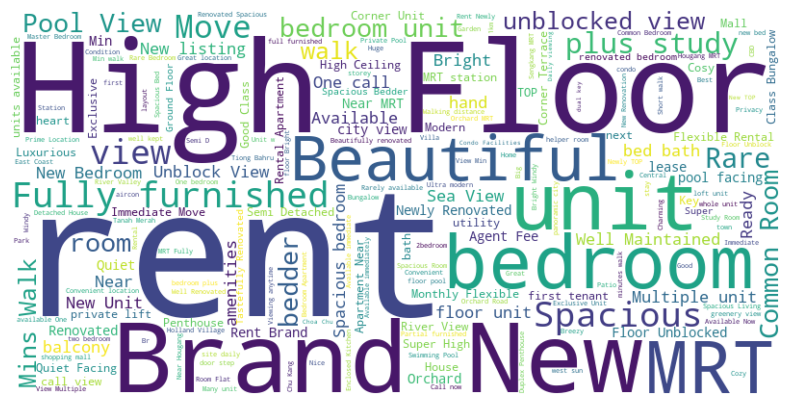

In [262]:
# Combine all agent descriptions into a single string
text = " ".join(df["agent_description"])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white", random_state=7)

# Create a word cloud of the agent descriptions
wordcloud.generate(text)

# Display the word cloud 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Turn off the axis
plt.show()

In [263]:
# Save the word cloud as an image
# wordcloud.to_file("images/wordcloud.png")

Extract the following features: (1) High floor, (2) new, (3) renovated, (4) view and (5) penthouse.

## High floor

In [264]:
# Extract high floor information
df["high_floor"] = df["agent_description"].apply(lambda string: True if "high floor" in string.lower() else False)

In [265]:
# Frequency of high floor
df["high_floor"].value_counts()

False    4446
True      636
Name: high_floor, dtype: int64

## New

In [266]:
# Extract new feature
df["new"] = df["agent_description"].apply(lambda string: True if "brand new" in string.lower() or 
                                          "new unit" in string.lower() else False)

In [267]:
# Frequency of new
df["new"].value_counts()

False    4439
True      643
Name: new, dtype: int64

## Renovated

In [268]:
# Extract renovation information
df["renovated"] = df["agent_description"].apply(lambda string: True if "renovated" in string.lower() or 
                                                "renovation" in string.lower() else False)

In [269]:
# Frequency of renovated
df["renovated"].value_counts()

False    4626
True      456
Name: renovated, dtype: int64

## View

In [270]:
# Extract view feature
df["view"] = df["agent_description"].apply(lambda string: True if "sea view" in string.lower() 
                                           or "seaview" in string.lower() or "panoramic view" in string.lower()
                                           or "unblocked view" in string.lower() or "unblock view" in string.lower()
                                           or "stunning view" in string.lower() or "park view" in string.lower() 
                                           or "breathtaking view" in string.lower() or "river view" in string.lower() 
                                           or "pool view" in string.lower() or "spectacular view" in string.lower()                                          
                                           or "city view" in string.lower() or "greenery view" in string.lower() 
                                           or "gorgeous view" in string.lower() else False)

In [271]:
# Frequency of view
df["view"].value_counts()

False    4428
True      654
Name: view, dtype: int64

## Penthouse

In [272]:
# Extract penthouse information
df["penthouse"] = df["agent_description"].apply(lambda string: True if "penthouse" in string.lower() else False)

In [273]:
# Frequency of penthouse
df["penthouse"].value_counts()

False    4972
True      110
Name: penthouse, dtype: int64

# Convert data types

In [274]:
# Convert price from str to int
df["price"] = df["price"].str.replace(",", "").astype("Int32")

In [275]:
# Convert size (sqft) from str to int
df["size"] = df["size"].str.split("sqft").str[0].astype("Int32")

In [276]:
# Convert bathrooms from str to int
df["bathrooms"] = df["bathrooms"].astype("Int32")

In [277]:
# Convert meters_to_school from float to int
df["meters_to_school"] = df["meters_to_school"].astype("Int32")

# Handle missing values

## Bathrooms

In [278]:
# Average number of bathrooms by number of bedrooms
np.round(df["bathrooms"].groupby(df["bedrooms"]).mean(), 1)

bedrooms
1          1.1
10        10.0
2          1.7
3          2.5
4          4.1
5          5.3
6          5.8
7          6.6
8          8.1
9          8.0
Room      <NA>
Studio    <NA>
Name: bathrooms, dtype: Float64

In [279]:
# Assume 1 bathroom for a studio
df["bathrooms"][df["bedrooms"]=="Studio"] = 1
# Assume 1 bathroom for a room in a shared flat
df["bathrooms"][df["bedrooms"]=="Room"] = 1
# Else assume the same number as bedrooms
df["bathrooms"][pd.isna(df["bathrooms"])] = df["bedrooms"]

## Latitude and longitude

In [280]:
# Delete rows where latitude or longitude is missing 
df.dropna(subset=["latitude", "longitude"], how="any", inplace=True)

## Meters to school

In [281]:
# Descriptive statistics of meters to school
df["meters_to_school"].describe()

count    4737.000000
mean     1475.897615
std       843.668011
min         0.000000
25%       927.000000
50%      1335.000000
75%      1821.000000
max      9042.000000
Name: meters_to_school, dtype: float64

In [282]:
# Impute the maximum value if meters to school are missing
max_meters_to_school = df["meters_to_school"].max()
df["meters_to_school"] = df["meters_to_school"].fillna(max_meters_to_school)

## Meters to MRT

In [283]:
# Descriptive statistics of meters to MRT
df["meters_to_mrt"].describe()

count    4165.000000
mean      459.193277
std       223.646902
min        20.000000
25%       270.000000
50%       450.000000
75%       610.000000
max       990.000000
Name: meters_to_mrt, dtype: float64

In [284]:
# Impute the median if meters to MRT are missing
median_meters_to_mrt = df["meters_to_mrt"].median()
df["meters_to_mrt"] = df["meters_to_mrt"].fillna(median_meters_to_mrt)

## Furnishing

In [285]:
# Frequencies of furnishing
df["furnishing"].value_counts()

Partially Furnished    2880
Fully Furnished        1476
Unfurnished              74
Name: furnishing, dtype: int64

In [286]:
# Impute the mode if furnishing information is missing
mode_furnishing = df["furnishing"].mode()[0]
df["furnishing"] = df["furnishing"].fillna(mode_furnishing)

## Built year

In [287]:
# Descriptive statistics of built year
df["year"].describe()

count    4128.000000
mean     2009.596899
std        12.065780
min      1971.000000
25%      2004.000000
50%      2012.000000
75%      2017.000000
max      2024.000000
Name: year, dtype: float64

In [288]:
# Impute the median if built year is missing
median_year = df["year"].median()
df["year"] = df["year"].fillna(median_year)

# Check data

In [289]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4754 entries, 0 to 5081
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           4754 non-null   object 
 1   address                        4754 non-null   object 
 2   price                          4754 non-null   Int32  
 3   size                           4754 non-null   Int32  
 4   bedrooms                       4754 non-null   object 
 5   bathrooms                      4754 non-null   Int32  
 6   property_type_furnishing_year  4754 non-null   object 
 7   mrt_distance                   4165 non-null   object 
 8   agent_description              4754 non-null   object 
 9   latitude                       4754 non-null   float64
 10  longitude                      4754 non-null   float64
 11  school_location                4737 non-null   object 
 12  meters_to_school               4754 non-null   I

In [290]:
# Show top and bottom five rows
df

,name,address,price,size,bedrooms,bathrooms,property_type_furnishing_year,mrt_distance,agent_description,latitude,...,address_new,property_type,furnishing,year,meters_to_mrt,high_floor,new,renovated,view,penthouse
0,"Brand new Attic Studio, in a Peranakan Conserv...",Lorong 34 Geylang,3000,400,1,1,\nApartment\nFully Furnished\n,NaN,One and only attic studio! Beautifully done up...,1.312952,...,Lorong 34 Geylang,Apartment,Fully Furnished,2012,450,False,False,False,False,False
1,Astor,51C Lengkong Empat,2000,1130,Room,1,\nApartment\nFully Furnished\n,11 mins (810 m) to DT28 Kaki Bukit MRT,Comes with In House Maid,1.328820,...,51C Lengkong Empat,Apartment,Fully Furnished,2012,810,False,False,False,False,False
2,Springhill Terrace,Sunrise avenue,7400,3800,5,4,\nApartment\nFully Furnished\n,NaN,"Close to MRT and short drive to French, Austra...",1.389444,...,Sunrise avenue,Apartment,Fully Furnished,2012,450,False,False,False,False,False
3,704 Yishun Avenue 5,704 Yishun Avenue 5,1000,120,Room,1,\nApartment\nFully Furnished\n,9 mins (700 m) to NS13 Yishun MRT,Room for 1 or 2 single ladies,1.429261,...,704 Yishun Avenue 5,Apartment,Fully Furnished,2012,700,False,False,False,False,False
4,Espada,48 Saint Thomas Walk,4300,689,1,1,\nApartment\nFully Furnished\n,6 mins (420 m) to NS23 Somerset MRT,All units virtual online viewing available! An...,1.297356,...,48 Saint Thomas Walk,Apartment,Fully Furnished,2012,420,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5077,Avenue South Residence,13 Silat Avenue,7500,947,3,2,\nBungalow House\nPartially Furnished\n,NaN,Newly TOP! Be the first to stay near town!,1.276469,...,13 Silat Avenue,Bungalow House,Partially Furnished,2012,450,False,False,False,False,False
5078,453B Fernvale Road,453B Fernvale Road,999,150,Room,1,\nBungalow House\nPartially Furnished\n,4 mins (290 m) to SW5 Fernvale LRT,Close to fernvale LRT,1.393888,...,453B Fernvale Road,Bungalow House,Partially Furnished,2012,290,False,False,False,False,False
5079,Riviere,1 Jiak Kim Street,8000,840,2,2,\nBungalow House\nPartially Furnished\n,5 mins (370 m) to TE16 Havelock MRT,Brand new pool facing unit!,1.291419,...,1 Jiak Kim Street,Bungalow House,Partially Furnished,2012,370,False,True,False,False,False
5080,Bukit Villas,1 Rasok Drive,7100,3025,5,4,\nBungalow House\nPartially Furnished\n,NaN,"Tranquil surroundings, facilities included! Po...",1.416662,...,1 Rasok Drive,Bungalow House,Partially Furnished,2012,450,False,False,False,False,False


# Exploratory data analysis

## Remove further duplicates

In [291]:
df.duplicated(subset=["name", "price", "size"]).value_counts()

True     3178
False    1576
dtype: int64

In [292]:
df = df.drop_duplicates(subset=["name", "price", "size"]).copy()

In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1576 entries, 0 to 4782
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           1576 non-null   object 
 1   address                        1576 non-null   object 
 2   price                          1576 non-null   Int32  
 3   size                           1576 non-null   Int32  
 4   bedrooms                       1576 non-null   object 
 5   bathrooms                      1576 non-null   Int32  
 6   property_type_furnishing_year  1576 non-null   object 
 7   mrt_distance                   1392 non-null   object 
 8   agent_description              1576 non-null   object 
 9   latitude                       1576 non-null   float64
 10  longitude                      1576 non-null   float64
 11  school_location                1574 non-null   object 
 12  meters_to_school               1576 non-null   I

## Numerical columns

In [294]:
# Store numerical columns
numerical_columns = ["price", "size", "bathrooms", "meters_to_mrt", "meters_to_school", "year"]

### Table: Descriptive statistics 

In [295]:
# Overview of descriptive statistics of all numerical columns
df[numerical_columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,1576.0,8692.596447,11629.167738,500.0,3950.0,5200.0,8500.00,108000.0
size,1576.0,1521.704315,1822.254935,50.0,635.0,980.0,1532.25,20000.0
bathrooms,1576.0,2.376269,1.449657,1.0,1.0,2.0,3.00,9.0
meters_to_mrt,1576.0,460.996193,213.259416,20.0,300.0,450.0,590.00,990.0
meters_to_school,1576.0,1499.831218,936.114234,0.0,934.0,1340.5,1838.25,9042.0
year,1576.0,2010.553934,10.982104,1974.0,2008.0,2012.0,2018.00,2024.0


### Price

In [296]:
# Descriptive statistics
df["price"].describe()

count      1576.000000
mean       8692.596447
std       11629.167738
min         500.000000
25%        3950.000000
50%        5200.000000
75%        8500.000000
max      108000.000000
Name: price, dtype: float64

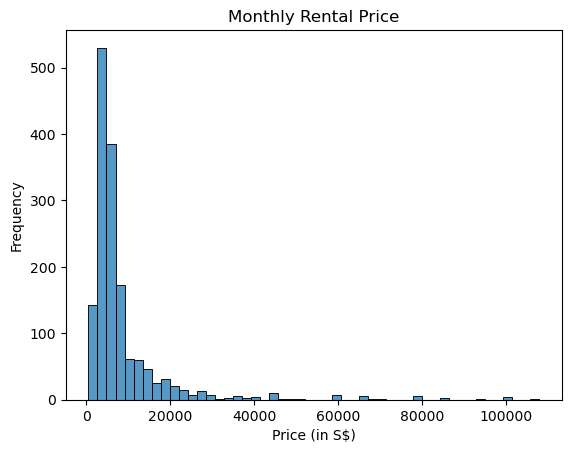

In [297]:
# Create a histogram 
sns.histplot(df["price"], bins=50)

# Add axes labels 
plt.xlabel("Price (in S$)")
plt.ylabel("Frequency")

# Set x-axis limits
# plt.xlim(0, 15000)

# Add title
plt.title("Monthly Rental Price")

# Show the plot
plt.show()

#### Price correlations

In [298]:
# Correlations between price and all numerical and dichotomous columns
df[["price", "size", "bathrooms", "meters_to_mrt", "meters_to_school", "year", "high_floor", "new", "renovated", 
    "view", "penthouse"]].corr()["price"]

price               1.000000
size                0.858560
bathrooms           0.711108
meters_to_mrt       0.061943
meters_to_school    0.055221
year                0.026369
high_floor         -0.046527
new                -0.083549
renovated           0.000794
view               -0.040790
penthouse           0.137356
Name: price, dtype: float64

#### Price scatterplots

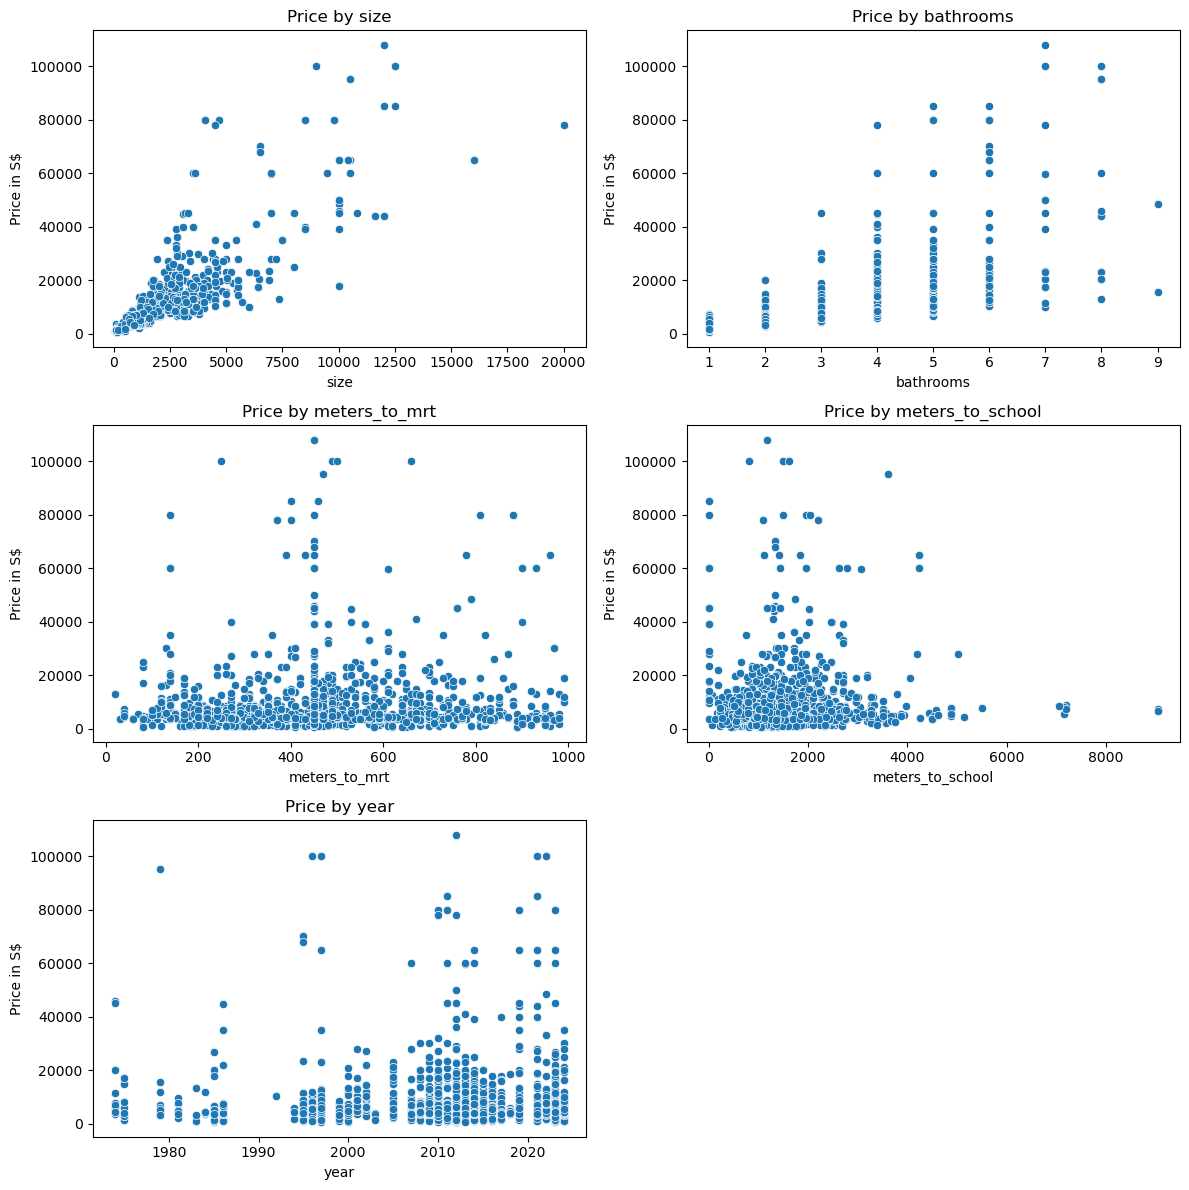

In [354]:
# Set the figure size
plt.figure(figsize=(12, 12))

# Iterate over the five numerical columns
for i, col in enumerate(["size", "bathrooms", "meters_to_mrt", "meters_to_school", "year"]):
    # Create a subplot in a 2x3 grid, the current subplot is i+1
    plt.subplot(3, 2, i + 1)
    # Create a scatter plot between the current column and price
    sns.scatterplot(data=df, x=col, y="price")
    # Add axis labels
    plt.ylabel("Price in S$")
    plt.xlabel(f"{col}")
    # Add title
    plt.title(f"Price by {col}")

# Adjust subplot layout
plt.tight_layout()

# Show the plot
plt.show()

#### Price by bedrooms

In [299]:
# Descriptive statistics of price by bedrooms
price_by_bedrooms = df["price"].groupby(df["bedrooms"])
price_by_bedrooms.describe()

,count,mean,std,min,25%,50%,75%,max
bedrooms,,,,,,,,
1,205.0,4044.82439,1027.782678,1200.0,3350.0,3999.0,4500.0,7188.0
2,427.0,5035.447307,1469.02597,2900.0,4000.0,4700.0,5600.0,13800.0
3,471.0,7071.324841,3970.169766,3300.0,4500.0,6000.0,8250.0,36000.0
4,194.0,17539.510309,12097.587037,4000.0,9800.0,15000.0,20000.0,80000.0
5,77.0,27461.025974,23258.306865,5500.0,12000.0,17000.0,39000.0,108000.0
6,30.0,32262.933333,26753.783185,8500.0,12575.0,21000.0,45666.0,100000.0
7,11.0,40272.727273,38950.843146,9500.0,14000.0,18000.0,67500.0,100000.0
8,3.0,51462.666667,40287.643035,15500.0,29694.0,43888.0,69444.0,95000.0
9,1,43888.0,<NA>,43888,43888,43888,43888,43888


In [300]:
# Store median price by bedrooms in the desired order
median_price_by_bedrooms = price_by_bedrooms.median().reindex(["Room", "Studio", "1", "2", "3", "4", "5", "6", "7", 
                                                              "8", "9"])

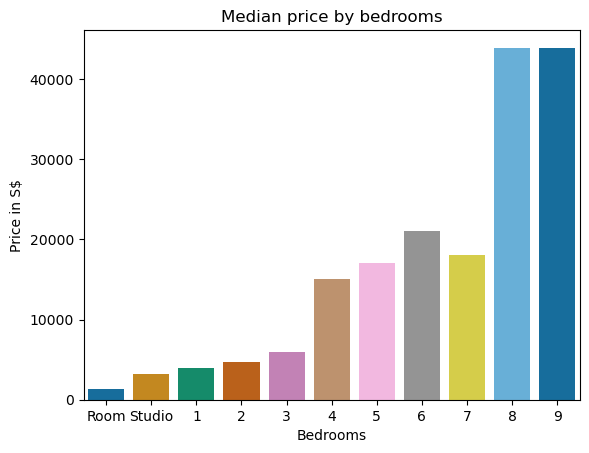

In [301]:
# Bar plot
sns.barplot(x=median_price_by_bedrooms.index, y=median_price_by_bedrooms.values, palette="colorblind")

# Add axes labels 
plt.ylabel("Price in S$")
plt.xlabel("Bedrooms")

# Add title
plt.title("Median price by bedrooms")

# Show the plot
plt.show()

#### Price by property type

In [302]:
# Descriptive statistics of price by property type
price_by_type = df["price"].groupby(df["property_type"])
price_by_type.describe()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Apartment,325.0,8416.676923,11561.416770,550.0,4000.00,5100.0,8200.00,108000.0
Cluster House,8.0,4937.500000,1371.065800,1800.0,4725.00,5500.0,5600.00,6200.0
Condominium,833.0,8818.907563,11788.064753,790.0,3950.00,5200.0,8500.00,100000.0
Corner Terrace,46.0,7115.391304,5954.439768,1500.0,4022.00,5150.0,8375.00,39000.0
Detached House,21.0,16632.761905,20552.127388,900.0,5000.00,7200.0,23500.00,85000.0
Good Class Bungalow,30.0,7643.166667,7516.636964,700.0,4050.00,5400.0,7999.75,39000.0
HDB Flat,198.0,8418.292929,11961.575300,500.0,3800.00,4800.0,7499.75,95000.0
Semi-Detached House,88.0,8689.761364,10985.835841,1100.0,3974.25,5200.0,9125.00,85000.0
Terraced House,27.0,8927.777778,8896.072315,1700.0,4325.00,5800.0,11150.00,45000.0


In [303]:
# Store median price by property type in the desired order
median_price_by_type = price_by_type.median().reindex(["HDB Flat", "Apartment", "Condominium", "Corner Terrace",
                                                      "Semi-Detached House", "Good Class Bungalow", "Cluster House",
                                                      "Terraced House", "Detached House"])
median_price_by_type

property_type
HDB Flat               4800.0
Apartment              5100.0
Condominium            5200.0
Corner Terrace         5150.0
Semi-Detached House    5200.0
Good Class Bungalow    5400.0
Cluster House          5500.0
Terraced House         5800.0
Detached House         7200.0
Name: price, dtype: Float64

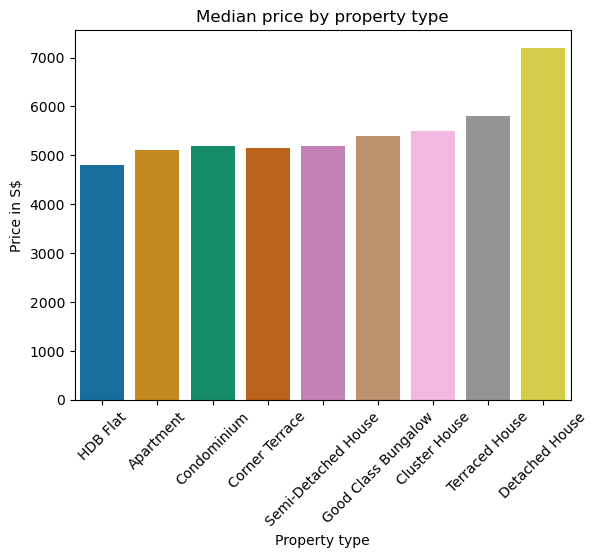

In [304]:
# Bar plot
sns.barplot(x=median_price_by_type.index, y=median_price_by_type.values, palette="colorblind")

# Add axes labels
plt.xlabel("Property type")
plt.ylabel("Price in S$")

# Rotate x-axis tick labels by 45 degrees
plt.xticks(rotation=45)

# Add title
plt.title("Median price by property type")

# Show the plot
plt.show()

#### Price by furnishing

In [305]:
# Descriptive statistics of price by furnishing
price_by_furnishing = df["price"].groupby(df["furnishing"])
price_by_furnishing.describe()

,count,mean,std,min,25%,50%,75%,max
furnishing,,,,,,,,
Fully Furnished,475.0,8175.113684,10753.832052,500.0,3800.00,5000.0,8000.0,100000.0
Partially Furnished,1073.0,8896.333644,11994.548923,550.0,4000.00,5250.0,8500.0,108000.0
Unfurnished,28.0,9663.821429,11796.904641,1200.0,3749.75,6450.0,12050.0,65000.0


In [306]:
# Store median price by furnishing
median_price_by_furnishing = price_by_furnishing.median()

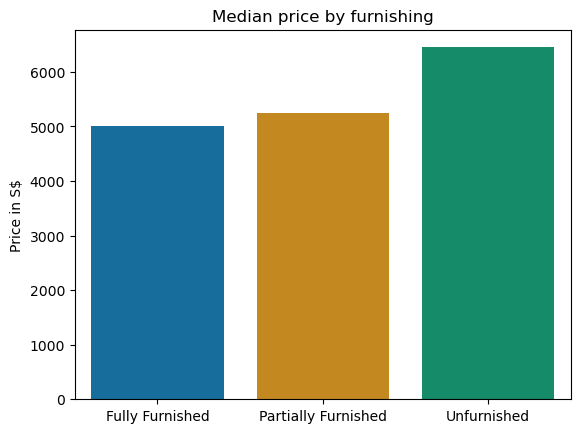

In [307]:
# Bar plot
sns.barplot(x=median_price_by_furnishing.index, y=median_price_by_furnishing.values, palette="colorblind")

# Add axes labels
plt.ylabel("Price in S$")
plt.xlabel("")

# Add title
plt.title("Median price by furnishing")

# Show the plot
plt.show()

#### Price by high floor, new, renovated, view and penthouse

In [338]:
# Descriptive statistics of price by high floor, new, renovated, view and penthouse
for col in ["high_floor", "new", "renovated", "view", "penthouse"]:
    print(f"Price by {col}:")
    print(round(df["price"].groupby(df[col]).describe()))
    print("-" * 80)

Price by high_floor:
             count    mean      std    min     25%     50%     75%       max
high_floor                                                                  
False       1374.0  8900.0  12258.0  500.0  3900.0  5100.0  8500.0  108000.0
True         202.0  7282.0   5563.0  800.0  4225.0  5500.0  7500.0   39000.0
--------------------------------------------------------------------------------
Price by new:
        count    mean      std     min     25%     50%     75%       max
new                                                                     
False  1415.0  9020.0  12148.0   500.0  3950.0  5300.0  8800.0  108000.0
True    161.0  5813.0   4221.0  1500.0  3950.0  4800.0  6400.0   39000.0
--------------------------------------------------------------------------------
Price by renovated:
            count    mean      std    min     25%     50%     75%       max
renovated                                                                  
False      1440.0  8690.0  1148

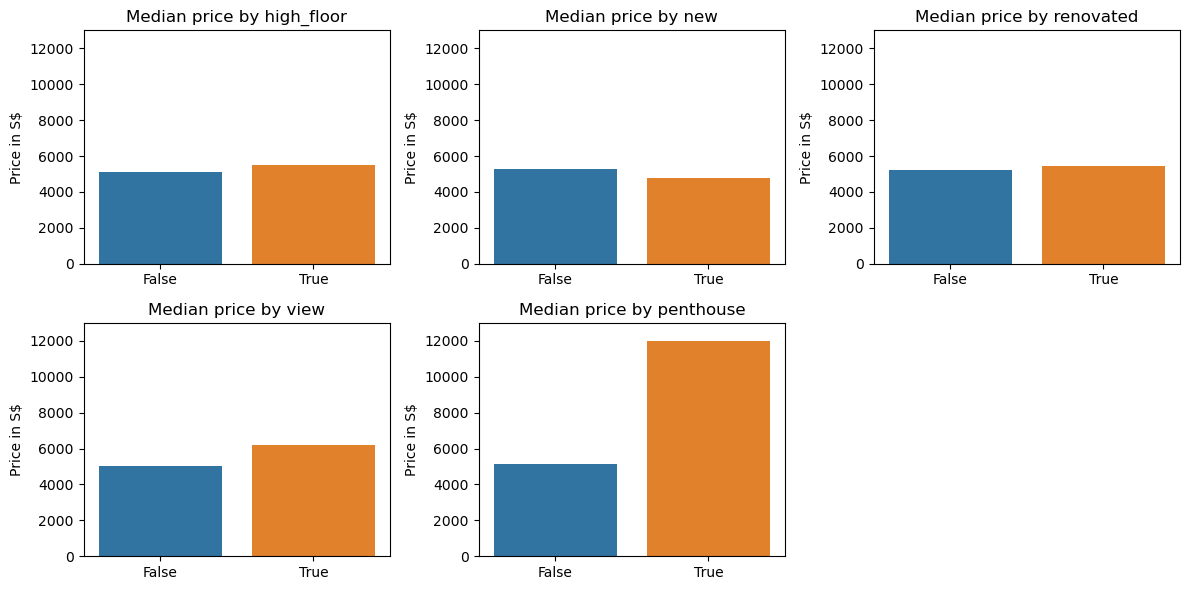

In [327]:
# Bar plots of price by high floor, new, renovated, view and penthouse
# Set the figure size
plt.figure(figsize=(12, 6))

# Iterate over the five dichotomous columns
for i, col in enumerate(["high_floor", "new", "renovated", "view", "penthouse"]):
    # Create a subplot in a 2x3 grid, the current subplot is i+1
    plt.subplot(2, 3, i + 1)
    # Create a bar plot of median price by the current column
    ax = sns.barplot(data=df, x=col, y="price", estimator=np.median, ci=None)
    # Add axes labels
    plt.ylabel("Price in S$")
    plt.xlabel("")
    # Set y-axis limits
    ax.set_ylim(0, 13000)
    # Add title
    plt.title(f"Median price by {col}")

# Adjust subplot layout
plt.tight_layout()

# Show the plot
plt.show()

### Size

In [94]:
# Descriptive statistics
df["size"].describe()

count     1576.000000
mean      1521.704315
std       1822.254935
min         50.000000
25%        635.000000
50%        980.000000
75%       1532.250000
max      20000.000000
Name: size, dtype: float64

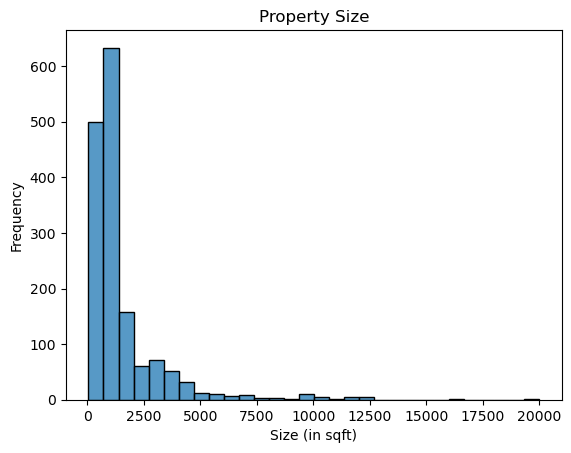

In [95]:
# Create a histogram 
sns.histplot(df["size"], bins=30)

# Add axes labels 
plt.xlabel("Size (in sqft)")
plt.ylabel("Frequency")

# Set x-axis limits
# plt.xlim(0, 3900)

# Add title
plt.title("Property Size")

# Show the plot
plt.show()

### Bathrooms

In [96]:
# Descriptive statistics
df["bathrooms"].describe()

count    1576.000000
mean        2.376269
std         1.449657
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         9.000000
Name: bathrooms, dtype: float64

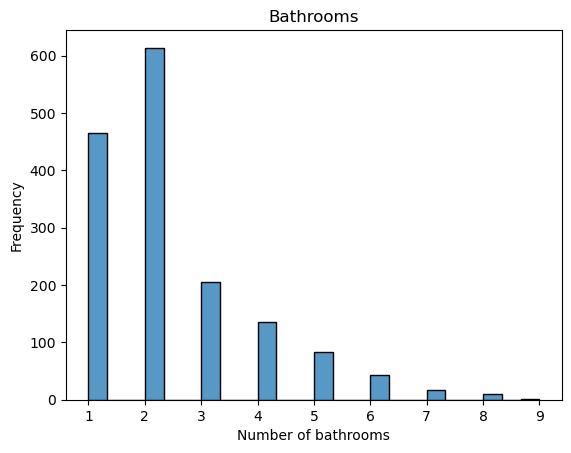

In [97]:
# Create a histogram 
sns.histplot(df["bathrooms"])

# Add axes labels 
plt.xlabel("Number of bathrooms")
plt.ylabel("Frequency")

# Add title
plt.title("Bathrooms")

# Show the plot
plt.show()

### Meters to MRT

In [98]:
# Descriptive statistics
df["meters_to_mrt"].describe()

count    1576.000000
mean      460.996193
std       213.259416
min        20.000000
25%       300.000000
50%       450.000000
75%       590.000000
max       990.000000
Name: meters_to_mrt, dtype: float64

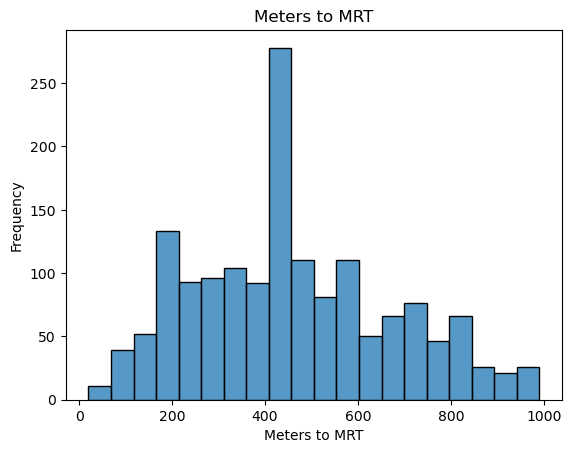

In [99]:
# Create a histogram 
sns.histplot(df["meters_to_mrt"])

# Add axes labels 
plt.xlabel("Meters to MRT")
plt.ylabel("Frequency")

# Add title
plt.title("Meters to MRT")

# Show the plot
plt.show()

### Meters to school

In [100]:
# Descriptive statistics
df["meters_to_school"].describe()

count    1576.000000
mean     1499.831218
std       936.114234
min         0.000000
25%       934.000000
50%      1340.500000
75%      1838.250000
max      9042.000000
Name: meters_to_school, dtype: float64

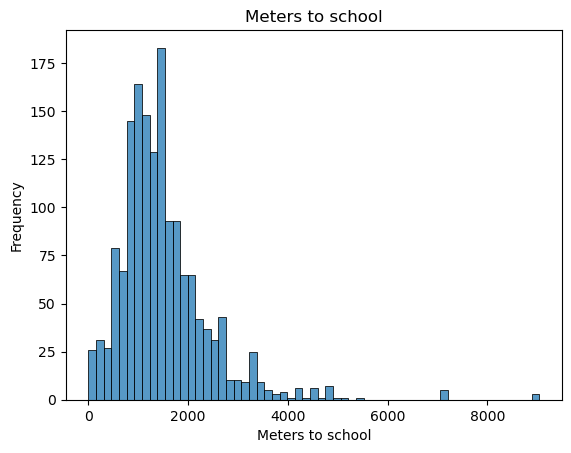

In [101]:
# Create a histogram 
sns.histplot(df["meters_to_school"])

# Add axes labels 
plt.xlabel("Meters to school")
plt.ylabel("Frequency")

# Add title
plt.title("Meters to school")

# Show the plot
plt.show()

### Built year

In [102]:
# Descriptive statistics
df["year"].describe()

count    1576.000000
mean     2010.553934
std        10.982104
min      1974.000000
25%      2008.000000
50%      2012.000000
75%      2018.000000
max      2024.000000
Name: year, dtype: float64

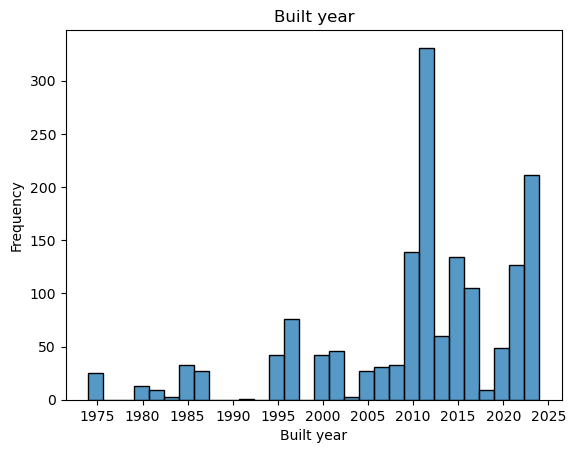

In [103]:
# Create a histogram 
sns.histplot(df["year"])

# Set x-axis markers every 5 years
plt.xticks(range(1975, 2026, 5))

# Add axes labels 
plt.xlabel("Built year")
plt.ylabel("Frequency")

# Add title
plt.title("Built year")

# Show the plot
plt.show()

## Categorical columns

In [104]:
# Store categorical columns
categorical_columns = ["bedrooms", "property_type", "furnishing", "high_floor", "new", "renovated", "view", 
                       "penthouse"]

### Bedrooms

In [105]:
# Calculate frequencies
bedrooms_freq = df["bedrooms"].value_counts()

# Reorder categories
bedrooms_freq = bedrooms_freq.reindex(["Room", "Studio", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

# Display frequencies
print("Absolute frequencies:")
print(bedrooms_freq)

print("\nRelative frequencies:")
for category, frequency in bedrooms_freq.iteritems():
    print(f"{category}: {100 * frequency/bedrooms_freq.sum():.1f}%")

Absolute frequencies:
Room      133
Studio     24
1         205
2         427
3         471
4         194
5          77
6          30
7          11
8           3
9           1
Name: bedrooms, dtype: int64

Relative frequencies:
Room: 8.4%
Studio: 1.5%
1: 13.0%
2: 27.1%
3: 29.9%
4: 12.3%
5: 4.9%
6: 1.9%
7: 0.7%
8: 0.2%
9: 0.1%


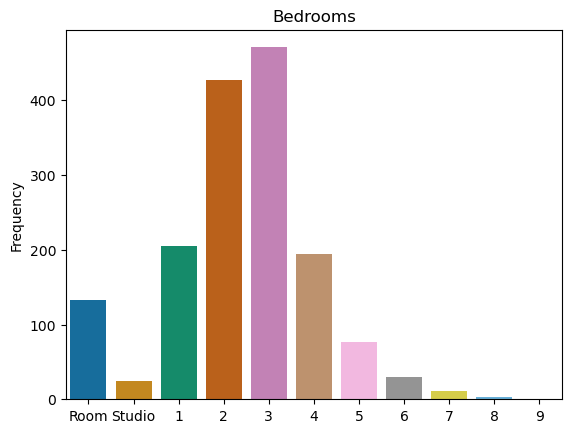

In [106]:
# Bar plot
sns.barplot(x=bedrooms_freq.index, y=bedrooms_freq.values, palette="colorblind")

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("Bedrooms")

# Show the plot
plt.show()

### Property type

In [107]:
# Calculate frequencies
property_type_freq = df["property_type"].value_counts()

# Display frequencies
print("Absolute frequencies:")
print(property_type_freq)

print("\nRelative frequencies:")
for category, frequency in property_type_freq.iteritems():
    print(f"{category}: {100 * frequency/property_type_freq.sum():.1f}%")

Absolute frequencies:
Condominium            833
Apartment              325
HDB Flat               198
Semi-Detached House     88
Corner Terrace          46
Good Class Bungalow     30
Terraced House          27
Detached House          21
Cluster House            8
Name: property_type, dtype: int64

Relative frequencies:
Condominium: 52.9%
Apartment: 20.6%
HDB Flat: 12.6%
Semi-Detached House: 5.6%
Corner Terrace: 2.9%
Good Class Bungalow: 1.9%
Terraced House: 1.7%
Detached House: 1.3%
Cluster House: 0.5%


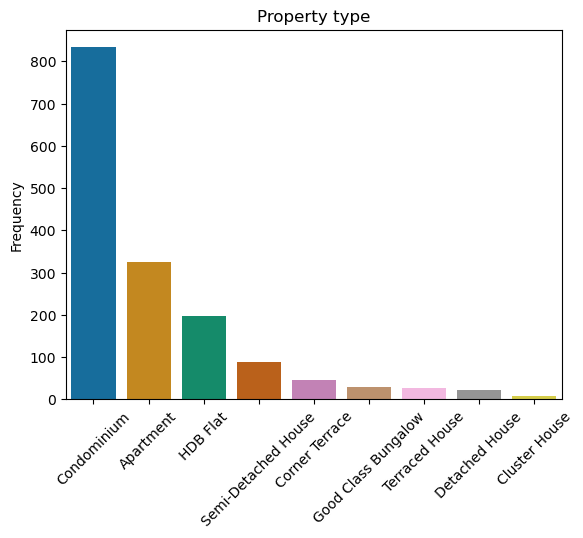

In [108]:
# Bar plot
sns.barplot(x=property_type_freq.index, y=property_type_freq.values, palette="colorblind")

# Add axes labels 
plt.ylabel("Frequency")

# Rotate x-axis tick labels by 45 degrees
plt.xticks(rotation=45)

# Add title
plt.title("Property type")

# Show the plot
plt.show()

### Furnishing

In [109]:
# Calculate frequencies
furnishing_freq = df["furnishing"].value_counts()

# Display frequencies
print("Absolute frequencies:")
print(furnishing_freq)

print("\nRelative frequencies:")
for category, frequency in furnishing_freq.iteritems():
    print(f"{category}: {100 * frequency/furnishing_freq.sum():.1f}%")

Absolute frequencies:
Partially Furnished    1073
Fully Furnished         475
Unfurnished              28
Name: furnishing, dtype: int64

Relative frequencies:
Partially Furnished: 68.1%
Fully Furnished: 30.1%
Unfurnished: 1.8%


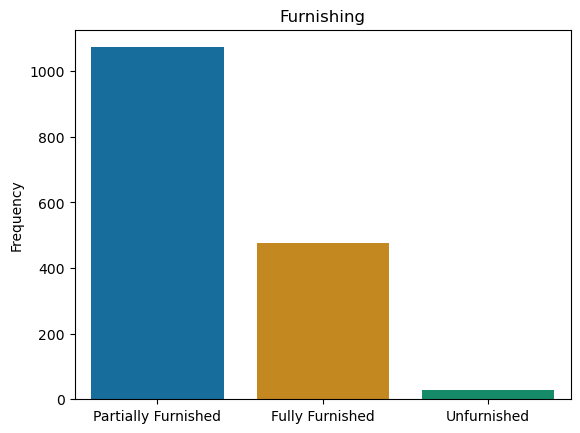

In [110]:
# Bar plot
sns.barplot(x=furnishing_freq.index, y=furnishing_freq.values, palette="colorblind")

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("Furnishing")

# Show the plot
plt.show()

### High floor

In [111]:
# Frequencies
print("Absolute frequencies:")
print(df["high_floor"].value_counts())

print("\nRelative frequencies:")
print(f'False: {np.round(100 * df["high_floor"].value_counts()[False] / df["high_floor"].value_counts().sum(), 1)}%')
print(f'True: {np.round(100 * df["high_floor"].value_counts()[True] / df["high_floor"].value_counts().sum(), 1)}%')

Absolute frequencies:
False    1374
True      202
Name: high_floor, dtype: int64

Relative frequencies:
False: 87.2%
True: 12.8%


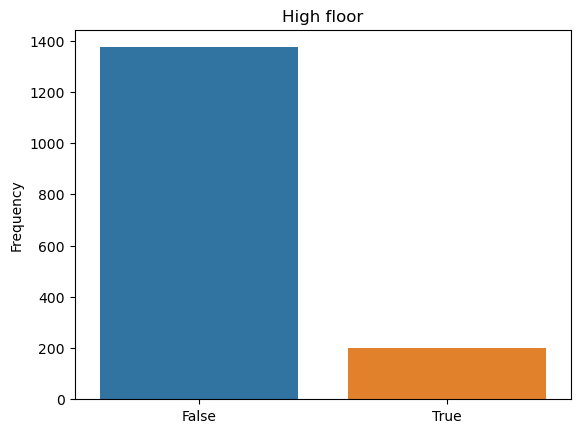

In [112]:
# Bar plot
sns.barplot(x=df["high_floor"].value_counts().index, y=df["high_floor"].value_counts().values)

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("High floor")

# Show the plot
plt.show()

### New

In [113]:
# Frequencies
print("Absolute frequencies:")
print(df["new"].value_counts())

print("\nRelative frequencies:")
print(f'False: {np.round(100 * df["new"].value_counts()[False] / df["new"].value_counts().sum(), 1)}%')
print(f'True: {np.round(100 * df["new"].value_counts()[True] / df["new"].value_counts().sum(), 1)}%')

Absolute frequencies:
False    1415
True      161
Name: new, dtype: int64

Relative frequencies:
False: 89.8%
True: 10.2%


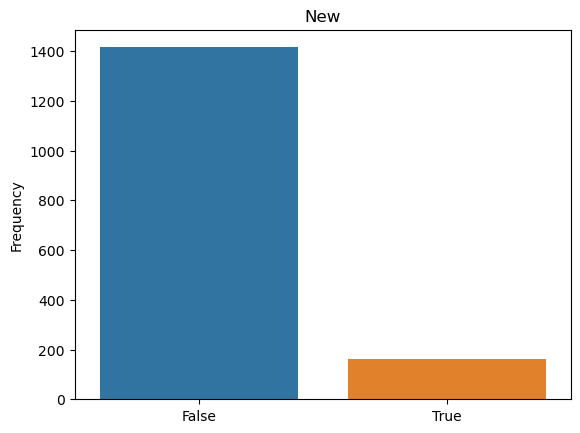

In [114]:
# Bar plot
sns.barplot(x=df["new"].value_counts().index, y=df["new"].value_counts().values)

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("New")

# Show the plot
plt.show()

### Renovated

In [115]:
# Frequencies
print("Absolute frequencies:")
print(df["renovated"].value_counts())

print("\nRelative frequencies:")
print(f'False: {np.round(100 * df["renovated"].value_counts()[False] / df["renovated"].value_counts().sum(), 1)}%')
print(f'True: {np.round(100 * df["renovated"].value_counts()[True] / df["renovated"].value_counts().sum(), 1)}%')

Absolute frequencies:
False    1440
True      136
Name: renovated, dtype: int64

Relative frequencies:
False: 91.4%
True: 8.6%


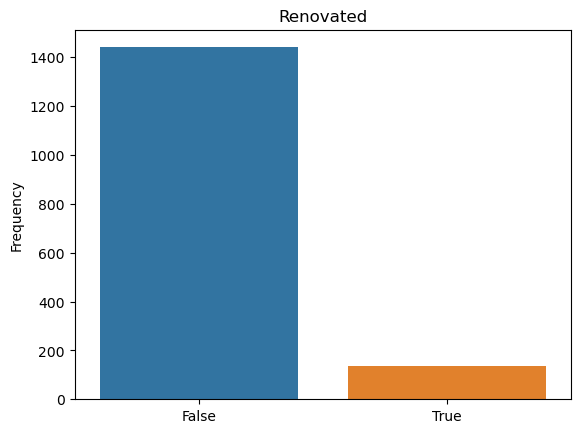

In [116]:
# Bar plot
sns.barplot(x=df["renovated"].value_counts().index, y=df["renovated"].value_counts().values)

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("Renovated")

# Show the plot
plt.show()

### View

In [117]:
# Frequencies
print("Absolute frequencies:")
print(df["view"].value_counts())

print("\nRelative frequencies:")
print(f'False: {np.round(100 * df["view"].value_counts()[False] / df["view"].value_counts().sum(), 1)}%')
print(f'True: {np.round(100 * df["view"].value_counts()[True] / df["view"].value_counts().sum(), 1)}%')

Absolute frequencies:
False    1367
True      209
Name: view, dtype: int64

Relative frequencies:
False: 86.7%
True: 13.3%


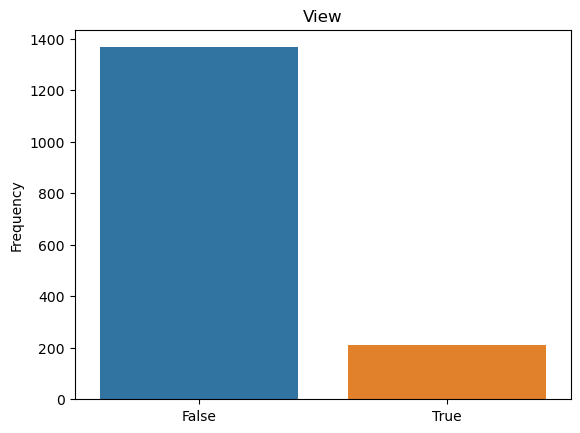

In [118]:
# Bar plot
sns.barplot(x=df["view"].value_counts().index, y=df["view"].value_counts().values)

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("View")

# Show the plot
plt.show()

### Penthouse

In [119]:
# Frequencies
print("Absolute frequencies:")
print(df["penthouse"].value_counts())

print("\nRelative frequencies:")
print(f'False: {np.round(100 * df["penthouse"].value_counts()[False] / df["penthouse"].value_counts().sum(), 1)}%')
print(f'True: {np.round(100 * df["penthouse"].value_counts()[True] / df["penthouse"].value_counts().sum(), 1)}%')

Absolute frequencies:
False    1543
True       33
Name: penthouse, dtype: int64

Relative frequencies:
False: 97.9%
True: 2.1%


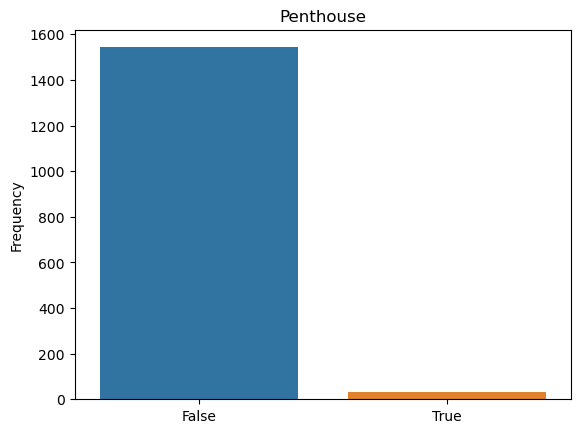

In [120]:
# Bar plot
sns.barplot(x=df["penthouse"].value_counts().index, y=df["penthouse"].value_counts().values)

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("Penthouse")

# Show the plot
plt.show()

## Correlations

In [374]:
# Calculate the correlation matrix 
corr_matrix = df[["price", "size", "bathrooms", "meters_to_mrt", "meters_to_school", "year", "high_floor", "new", 
                  "renovated", "view", "penthouse"]].corr()

# Round correlations to two decimals
corr_matrix = round(corr_matrix, 2)

# Create a mask to set the values in the upper triangle of the correlation matrix to NaN
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_matrix[mask] = np.nan

# Show correlation matrix
corr_matrix

,price,size,bathrooms,meters_to_mrt,meters_to_school,year,high_floor,new,renovated,view,penthouse
price,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size,0.86,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,0.71,0.83,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meters_to_mrt,0.06,0.12,0.12,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meters_to_school,0.06,0.06,0.07,-0.04,1.00,NaN,NaN,NaN,NaN,NaN,NaN
year,0.03,0.02,0.00,-0.03,-0.02,1.00,NaN,NaN,NaN,NaN,NaN
high_floor,-0.05,-0.10,-0.06,-0.07,0.02,-0.01,1.00,NaN,NaN,NaN,NaN
new,-0.08,-0.12,-0.14,0.06,-0.06,0.01,0.08,1.00,NaN,NaN,NaN
renovated,0.00,0.04,0.03,-0.02,-0.01,0.01,-0.03,-0.04,1.00,NaN,NaN
view,-0.04,-0.08,-0.02,-0.04,0.02,0.04,0.25,0.04,-0.05,1.00,NaN


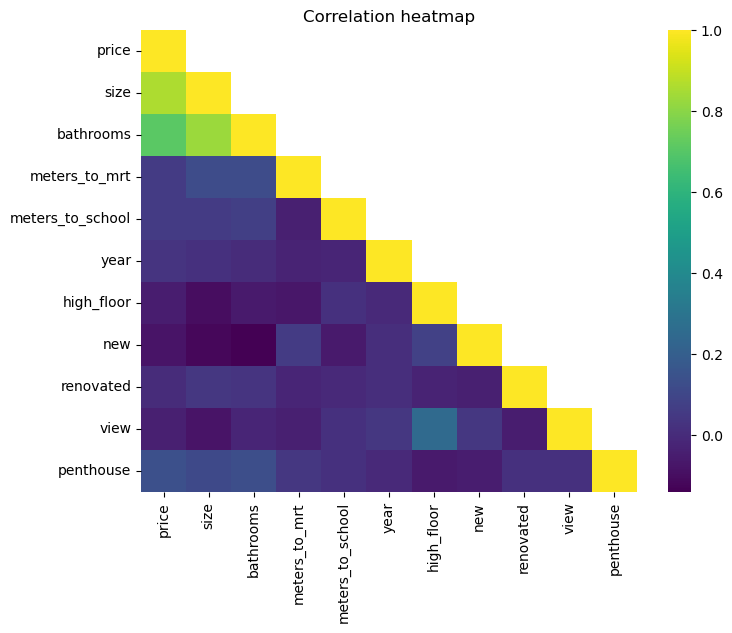

In [383]:
# Correlation heatmap
# Set the figure size
plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(corr_matrix, cmap="viridis")

# Add title
plt.title("Correlation heatmap")

# Save the heatmap as png
plt.savefig("images/correlation_heatmap.png", bbox_inches="tight")

# Show the plot
plt.show()

## Property locations on the map

In [375]:
import folium

In [376]:
# Create a map centered around Singapore
map = folium.Map(location=[1.3521, 103.8198], zoom_start=12) 

# Add property markers to the map
for index, row in df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        tooltip=row["name"],  # Display property name on hover
    ).add_to(map)

# Show map
map

In [ ]:
# Save the map as an HTML file
# map.save("images/map.html")  

# Save preprocessed data

In [ ]:
# Delete columns that are no longer needed
df.drop(["name", "address", "property_type_furnishing_year", "mrt_distance", "agent_description", "school_location", 
         "address_new"], axis=1, inplace=True)

In [ ]:
# Save preprocessed data as csv
# df.to_csv("data/rental_prices_singapore_preprocessed.csv", index=False)